# Installing and running libraries

In [1]:
#installing folium for better visualisations 

!pip install folium

In [3]:
#installing neptune client

!pip install neptune-client


In [4]:
#import neptune 

import neptune.new as neptune 

In [5]:
# Connect your code to Neptune new version 
import os
myProject = 'gaelkbertrand/google-stock-prediction'

neptune.init(project=myProject, 
             api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4YTc4ZTU1My01NGY3LTQ2YmMtODMxMi1iZWYxMzY4ZjQ2YzMifQ==')



https://app.neptune.ai/gaelkbertrand/google-stock-prediction/e/GOOG-2


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
#running neptune to log runs: not necessary if the above line run perfectly 

#run = neptune.init(project=project_name, api_token=api_token)

https://app.neptune.ai/gaelkbertrand/google-stock-prediction/e/GOOG-1


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Setting up a Google Drive working directory

In [6]:
#setting up a working_directory 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

! ls /content/drive/My\ Drive/1.ASP2022

import os
# This helps you setup your working directory to a folder in your Google Drive.
# Your files should be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
ML_final_project = "1.ASP2022/iml_final_project"

def create_and_set_working_directory(ML_final_project):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + ML_final_project) == False:
    os.mkdir(root_dir + ML_final_project)
    print(root_dir + ML_final_project + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + ML_final_project)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + ML_final_project + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(ML_final_project)

Mounted at /content/drive
 20220112_201807.mp4  'Calendars '
'Academic Documents'  'My account info.zip'
'Action plans'	       new_file_in_working_directory.txt
 Assignments	      'Online gaming competition Tech Min.pptx'
'Bank complaints'      Research
 Bullshit	       Work
/content/drive/My Drive/1.ASP2022/iml_final_project did not exist but was created.

Your working directory was changed to /content/drive/My Drive/1.ASP2022/iml_final_project

An empty text file was created there. You can also run !pwd to confirm the current working directory.


Install other libraries for ML

In [7]:
#installing other dependencies 

import os
import pandas as pd
import numpy as np

# for reproducibility of my prediction results
np.random.seed(42)

from datetime import date
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Model
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

import tensorflow as tf
tf.random.set_seed(42)



import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
os.chdir('/content/drive/My Drive/1.ASP2022/iml_final_project')


Recheck and verify your working directory

In [8]:
!pwd

/content/drive/My Drive/1.ASP2022/iml_final_project


# The ML project

Importing Google.inc stock data from Alpha Vantage

In [9]:
#import data from 'Alpha Vantage'

data_source= 'alphavantage'

if data_source == 'alphavantage':
    
    api_key = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4YTc4ZTU1My01NGY3LTQ2YmMtODMxMi1iZWYxMzY4ZjQ2YzMifQ=='
    # here, write your desired stock ticker symbol
    ticker = 'GOOGL' 
    
    # This is the JSON file with all the stock prices data 
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    fileName = 'stock_market_data-%s.csv'%ticker

    ### get the low, high, close, and open prices 
    if not os.path.exists(fileName):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # pull the desired stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for key,val in data.items():
                date = dt.datetime.strptime(key, '%Y-%m-%d')
                data_row = [date.date(),float(val['3. low']),float(val['2. high']),
                            float(val['4. close']),float(val['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        df.to_csv(fileName)

    else:
        print('Loading data from local')
        df = pd.read_csv(fileName)

Data preprocessing 

In [10]:
# Sort this DataFrame by date
stockprices = df.sort_values('Date')

Define functions that helps in calculating the performance: RMSE (Root Mean Square Error), MAPE (Mean absolute percentage error)

In [11]:
#### Define helper functions to calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Here, you can calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

### The effectiveness of prediction method is measured in terms of the Mean Absolute Percentage Error (MAPE) and RMSE
def calculate_mape(y_true, y_pred): 
    """
    Here, you can calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

Splitting the data into a training and test set

In [12]:
## Split the time-series data into a training sequence X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Arguments explanation:
        data - dataset 
        N - window size, e.g., 60 for 60 days 
        offset - position to start the split
    """
    X, y = [], []
    
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])
    
    return np.array(X), np.array(y)


#### Train-Test split for time-series ####
test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))

print("train_size: " + str(train_size))
print("test_size: " + str(test_size))

train = stockprices[:train_size][['Date', 'Close']]
test = stockprices[train_size:][['Date', 'Close']]


train_size: 3514
test_size: 878


# The LSTM (Long Short Term Memory) Model

Simple Moving Average calculation

In [13]:
stockprices = stockprices.set_index('Date')

### For meduim-term trading 
def plot_stock_trend(var, cur_title, stockprices=stockprices, logNeptune=True, logmodelName='Simple MA'):
    ax = stockprices[['Close', var,'200day']].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis('tight')
    plt.ylabel('Stock Price ($)')
    
    if logNeptune:
        npt_exp.log_image(f'Plot of Stock Predictions with {logmodelName}', ax.get_figure())
        
def calculate_perf_metrics(var, logNeptune=True, logmodelName='Simple MA'):
    ### RMSE 
    rmse = calculate_rmse(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:][var]))
    ### MAPE 
    mape = calculate_mape(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:][var]))
    
    if logNeptune:        
        npt_exp.send_metric('RMSE', rmse)
        npt_exp.log_metric('RMSE', rmse)
        
        npt_exp.send_metric('MAPE (%)', mape)
        npt_exp.log_metric('MAPE (%)', mape)
    
    return rmse, mape

# Here, 20 days represent the 22 trading days in a month
window_size = 50
CURRENT_MODEL = 'LSTM'

The model

In [34]:
#The model based on the model built by: Neptune.AI (https://neptune.ai/). Treat this as a formal citation of a reference. 

#neptune.create_experiment()

if CURRENT_MODEL == 'LSTM':

  layer_units, optimizer = 50, 'adam' 
  cur_epochs = 15
  cur_batch_size = 20

  cur_LSTM_pars = {'units': layer_units, 
                    'optimizer': optimizer, 
                    'batch_size': cur_batch_size, 
                    'epochs': cur_epochs
                    }

 # Create an experiment and log the model in Neptune new verison
  npt_exp = neptune.init(    
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4YTc4ZTU1My01NGY3LTQ2YmMtODMxMi1iZWYxMzY4ZjQ2YzMifQ==",
      project=myProject, 
      name='LSTM',         
      description='Google-stock-prediction-machine-learning', 
      tags=['stockprediction', 'LSTM','neptune'])   
  
  npt_exp['LSTMPars'] = cur_LSTM_pars


## Here, you have to use the past N stock prices for training to predict the N+1th closing price

 # scale 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[['Close']])
scaled_data_train = scaled_data[:train.shape[0]]

X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

### Build the LSTM model and log your model summary to Neptune to check on performance ###    
def Run_LSTM(X_train, layer_units=50, logNeptune=True, NeptuneProject=None):     
    inp = Input(shape=(X_train.shape[1], 1))
    
    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inp, out)
    
    # Compile the LSTM neural network
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    ## log into Neptune
   
    if logNeptune:
            model.summary(print_fn=lambda x: NeptuneProject['model_summary'].log(x))
    return model 

#Run the model
model = Run_LSTM(X_train, layer_units=layer_units, logNeptune=True, NeptuneProject=npt_exp)
    
history = model.fit(X_train, y_train, epochs=cur_epochs, batch_size=cur_batch_size, 
                    verbose=1, validation_split=0.1, shuffle=True)

#Now, you can predict stock prices using the past window_size stock prices
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=window_size, test=test):    
    raw = data['Close'][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)
    
    X_test = []
    for i in range(window_size, raw.shape[0]):
        X_test.append(raw[i-window_size:i, 0])
        
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

#Run it
X_test = preprocess_testdat()
  
predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot the predicted price versus the actual closing price 
test['Predictions_lstm'] = predicted_price   






https://app.neptune.ai/gaelkbertrand/google-stock-prediction/e/GOOG-8
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/15
156/156 [==============================] - 21s 112ms/step - loss: 0.0114 - val_loss: 0.0041
Epoch 2/15
156/156 [==============================] - 17s 106ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 3/15
156/156 [==============================] - 18s 113ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 4/15
156/156 [==============================] - 20s 131ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 5/15
156/156 [==============================] - 18s 115ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 6/15
156/156 [==============================] - 19s 125ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 7/15
156/156 [==============================] - 17s 111ms/step - loss: 0.0016 - val_loss

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


# Performance Evaluation

Evaluating the performance via RMSE and MAPE

In [40]:
rmse_lstm = calculate_rmse(np.array(test['Close']), np.array(test['Predictions_lstm']))
mape_lstm = calculate_mape(np.array(test['Close']), np.array(test['Predictions_lstm']))
# npt_exp.send_metric('RMSE', rmse_lstm)
# npt_exp.log_metric('RMSE', rmse_lstm)
npt_exp['RMSE'].log(rmse_lstm)  ## 12-18

# npt_exp.send_metric('MAPE (%)', mape_lstm)
# npt_exp.log_metric('MAPE (%)', mape_lstm)
npt_exp['MAPE (%)'].log(mape_lstm)

print('RMSE=', rmse_lstm, ':An error difference of 114. Pretty low compared to how Google stock changed in the last 18 years')
print('MAPE % =', mape_lstm, ':Good performance. An error of 3% difference between the actual price vs the predicted price.')

RMSE= 114.38063218855103 :An error difference of 114. Pretty low compared to how Google stock changed in the last 18 years
MAPE % = 3.354019131687904 :Good performance. An error of 3% difference between the actual price vs the predicted price.


Plotting Function Definition

Note: if you have color blindness, specify your preferred colors in the code below. 

In [42]:
### Plot prediction and true trends and log to Neptune         
def plot_stock_trend_lstm(train, test, logNeptune=True):        
    fig = plt.figure(figsize = (20,10))
    plt.plot(train['Date'], train['Close'], label = 'TRAIN Closing Price')
    plt.plot(test['Date'], test['Close'], label = 'TEST Closing Price')
    plt.plot(test['Date'], test['Predictions_lstm'], label = 'Predicted Closing Price')
    plt.title('Google inc stock price prediction using the LSTM Model: 2004-2022')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")
    
    ## Log image to Neptune new version
    if logNeptune:
        ## npt_exp.log_image('Plot of Stock Predictions with LSTM', fig)
        npt_exp['Plot of Stock Predictions with LSTM'].upload(neptune.types.File.as_image(fig))        

Plotting 

RMSE= 114.38063218855103 :An error difference of 114. Pretty low compared to how Google stock changed in the last 18 years
MAPE % = 3.354019131687904 :Good performance. An error of 3% difference between the actual price vs the predicted price.


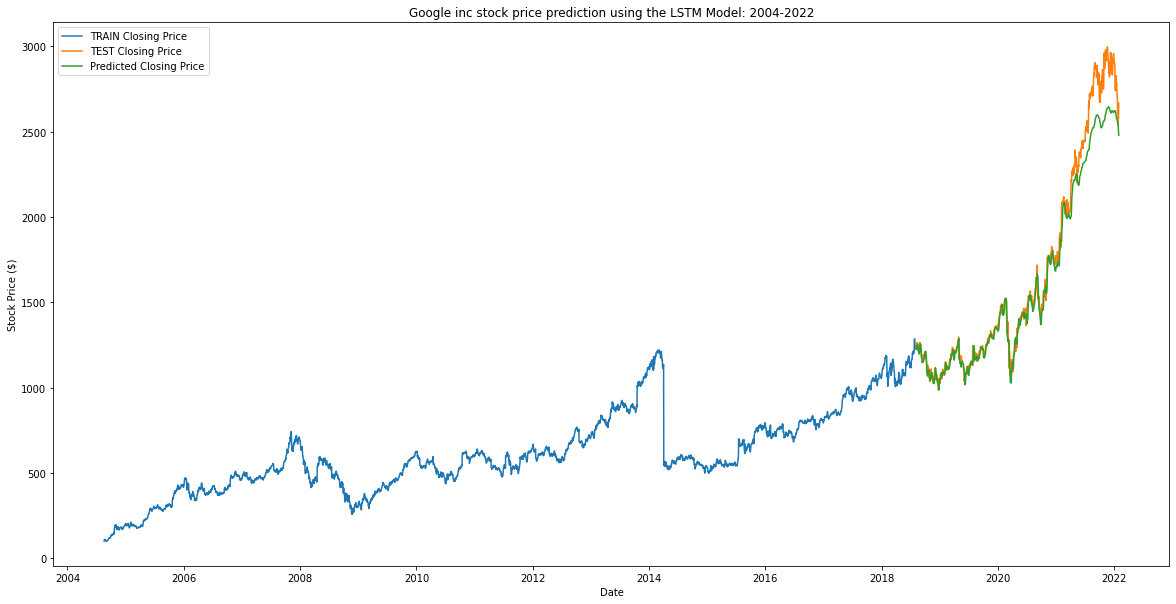

In [44]:
plot_stock_trend_lstm(train, test)
print('RMSE=', rmse_lstm, ':An error difference of 114. Pretty low compared to how Google stock changed in the last 18 years')
print('MAPE % =', mape_lstm, ':Good performance. An error of 3% difference between the actual price vs the predicted price.')

Stop the experiment 

In [45]:
npt_exp.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!
